## Life history traits model   

Taylor Chapter 3  
model to predict age-structured life history traits of understudied Carcharhinid species

Model versions: Same as models 26 & 27 except altered to enable prediction. one fixed-effect and one mixed-effect. covariates here are mean centred rather than z scores.  Need this because effect sizes need to be on the same scale as the raw data in order to calculate predicted values for a50 and s


### Set up notebook

In [1]:
#import packages
import datetime 
from itertools import product
import logging
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import os
from math import isnan
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import seaborn as sns
import pymc3 as pm  
from theano import tensor as tt
from theano import shared
import arviz as az
import warnings

%matplotlib inline  
#%matplotlib inline is a magic function that renders the figure in a notebook (instead of displaying a dump of the figure object)
from matplotlib import pyplot as plt 
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FuncFormatter, StrMethodFormatter


In [2]:
# Aaron Helper function
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: [ b.index(x) if x in b else None for x in a ]
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdise(x):
    return (x-np.mean(x))/(np.std(x)*2)

# Function to mean-centre covariates
def centre(x):
    return (x-np.mean(x))

def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

def gelplot(pj,vector,posy,csize=40,lwd50=7,lwd95=1):
    if np.percentile(vector,2.5)<0 and 0<np.percentile(vector,97.5):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='grey')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='grey')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='grey')
    else:
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='black')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='black')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='black')
        
    if np.percentile(vector,25)<0 and 0<np.percentile(vector,75):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='white')

In [3]:
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\in')
os.listdir() # list files in directory

['age_structured_traits.xlsx',
 'car_trait_covariates_v2.xlsx',
 'full_dataset.xlsx',
 'full_dataset_nosharpnose.xlsx',
 'predict_car_traits.xlsx',
 'species_level_traits_v1.xlsx',
 'tmp_car_traits.xlsx',
 '~$car_trait_covariates_v2.xlsx',
 '~$full_dataset.xlsx',
 '~$predict_car_traits.xlsx']

### Import and structure data

In [4]:
# Import full dataset
data = pd.read_excel('full_dataset.xlsx')
#get rid of species that don't have full complement of trait data
data = data[data.param_complete==0]

In [5]:
#list columns
data.columns

Index(['Species', 'Stock', 'Stock_Year', 'Age', 'maturity', 'survivorship',
       'fecundity (num female pups per year)', 'notes', 'model type',
       'source_mat', 'source_sur', 'source_fec', 'source_m_link',
       'source_s_link', 'source_f_link', 'Cortes_2018', 'SA_mat', 'SA_sur',
       'SA_fec', 'FP_species', 'habitat', 'trophic_level', 'offspring_size_mm',
       'litter_size', 'interbirth_interval_yrs', 'age_50_maturity',
       'length_maturity_cm', 'linf_cm', 'growth_coeff_k', 'lmax_cm',
       'age_max_yrs', 'temp_pref', 'nursery', 'depth_min', 'depth_max',
       'depth_ave', 'param_complete'],
      dtype='object')

In [6]:
# make datafame of only stocks which have age-structured maturity data
# only data rows where SA-mat A
mdata= data[data.SA_mat=='A']
mdata.shape

(560, 37)

In [7]:
# take out potential problem stocks
out = ['GSH-I-17', 'SPD-I-19', 'MLK-I-17']
mdata = mdata[~mdata.Stock_Year.isin(out)]

In [8]:
# make sure data is sorted properly
mdata = mdata.sort_values(by=['Stock_Year', 'Age'])

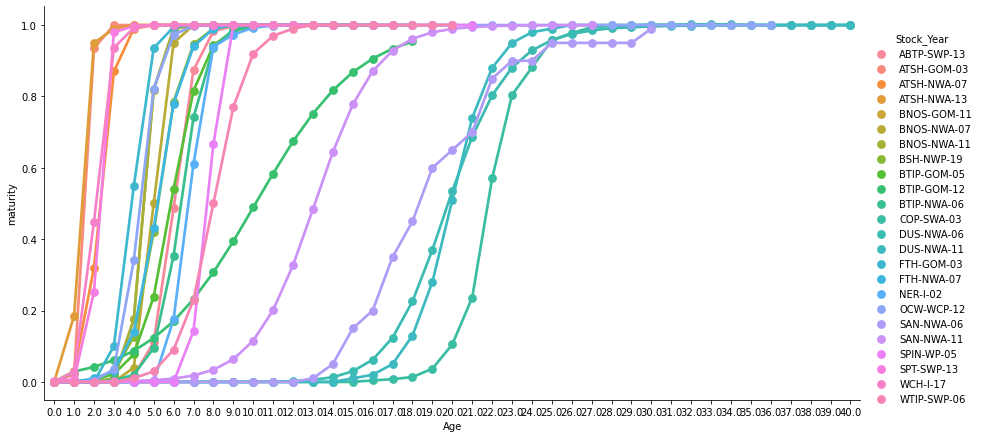

In [9]:
# visualise age-structured data
sns.catplot(x = "Age", y = "maturity", hue = "Stock_Year", height=6, aspect=2,
                kind="point", data = mdata);

## Format data

In [10]:
# Make arrays of response variables
AGE = mdata.Age.values
nobs = len(AGE)
MAT = mdata.maturity.values

In [11]:
# Make an index for stock-years 
# Puts an index value unique to the stock year for each row in df
StockYr, Is = indexall(mdata.Stock_Year.values)
nstocks = len(StockYr)
StockYr

['ABTP-SWP-13',
 'ATSH-GOM-03',
 'ATSH-NWA-07',
 'ATSH-NWA-13',
 'BNOS-GOM-11',
 'BNOS-NWA-07',
 'BNOS-NWA-11',
 'BSH-NWP-19',
 'BTIP-GOM-05',
 'BTIP-GOM-12',
 'BTIP-NWA-06',
 'COP-SWA-03',
 'DUS-NWA-06',
 'DUS-NWA-11',
 'FTH-GOM-03',
 'FTH-NWA-07',
 'NER-I-02',
 'OCW-WCP-12',
 'SAN-NWA-06',
 'SAN-NWA-11',
 'SPIN-WP-05',
 'SPT-SWP-13',
 'WCH-I-17',
 'WTIP-SWP-06']

In [12]:
#Index of covariates
Sind = np.array([list(mdata.Stock_Year.values).index(S) for S in StockYr])

#make arrays of all the covariates
#put Sind after all of these so they match the length of StockYr
rLMAX = mdata.lmax_cm.values[Sind]
rHAB = mdata.habitat.values[Sind]
rTROPH = mdata.trophic_level.values[Sind]
rOFFSZ = mdata.offspring_size_mm.values[Sind]
#rROFFSZ = mdata.relative_offspring_size.values[Sind]
rLITT = mdata.litter_size.values[Sind]
#RLITT = mdata.relative_litter_size.values[Sind]
rINTR = mdata.interbirth_interval_yrs.values[Sind]
rAMAT = mdata.age_50_maturity.values[Sind]
rLMAT = mdata.length_maturity_cm.values[Sind]
rLINF = mdata.linf_cm.values[Sind]
rK = mdata.growth_coeff_k.values[Sind]
rAMAX = mdata.age_max_yrs.values[Sind]
rDEP = mdata.depth_ave.values[Sind]
rDEPMAX = mdata.depth_max.values[Sind]
rTEMP = mdata.temp_pref.values[Sind]

In [49]:
np.mean(rK)

0.191107161

In [14]:
# mean centre all covariates
#change variable names

LMAX = centre(np.log(rLMAX))
TROPH = centre(rTROPH)
OFFSZ = centre(rOFFSZ/100)
LITT = centre(np.log(rLITT))
INTR = centre(rINTR)
LMAT = centre(np.log(rLMAT))
LINF = centre(np.log(rLINF))
K = centre(rK)
AMAX = centre(np.log(rAMAX))
DEP = centre(np.log(rDEP))
DEPMAX = centre(np.log(rDEPMAX))
TEMP = centre(np.log(rTEMP))

In [48]:
np.mean(AMAX)


-3.885780586188048e-16

# Bayes model

Maturity model has 2 parts to assess the 2 parameters which describe the maturity curve

$$m = \frac{1}{1+e^{-S}(a-a_{50})}$$


a50 null model:
$$
\small{
a_{50} \sim Normal(Ga_{50},\sigma a_{50}) \\ 
Ga_{50} \sim Uniform(1.5, 25)  \\
\sigma a_{50} \sim Exponential(0.5) 
}
$$



S null model:
$$
\small{
S \sim Normal(GS,\sigma S) \\
GS \sim Uniform(0.01, 10)  \\
\sigma S \sim Exponential(1) 
}
$$

### Model Specification

In [26]:
# random effects model with selected covariates
# same as model 33

with pm.Model() as mat1:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 0, 30) #mean a50 has uniform distribution from 1.5 to 25
    a50_sigma = pm.Exponential('a50_sigma', 0.5) #std dev of a50 is exponential distribution with lambda of 0.5
    a50 = pm.Normal('a50_', Ga50, a50_sigma, shape=nstocks) #likelihood of a50 values given distributions of Ga50 and sigma_a50 (I think... what is shape for?)
    # set up priors for slope values between a50 and covariates
    # first argument is just a name not an actual dataset - doesn't need to match name of data array
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3) # don't use Linf bc same thing as Lmax, also effect too similar to K
    β3 = pm.Normal('Depth', 0, 3)
    β4 = pm.Normal('K', 0, 3)
#    β5_ = pm.Normal ('Habitat', 0, tau=0.01, shape=nhabitats-1) # 
#    β5 = tt.set_subtensor(tt.zeros(shape=nhabitats)[1:], β5_)
    β6 = pm.Normal('Interbirth_interval', 0, 3)
    β7 = pm.Normal('Amax', 0, 3)
    β8 = pm.Normal('Litter', 0, 3)
    β9 = pm.Normal('Offspring_size', 0, 3)
    β10 = pm.Normal('Trophic', 0, 3)
#    β11 = pm.Normal('Lmat', 0, 3)  # Don't use Lmat because same thing as a50
    β12 = pm.Normal('Temperature', 0, 3)
    
    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
    S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
    S = pm.Normal('S_', GS, S_sigma, shape=nstocks) 
    
    # priors for covariates of S
    B1 = pm.Normal('Lmax-S', 0, 3)
    B3 = pm.Normal('Depth-S', 0, 3)
    B4 = pm.Normal('K-S', 0, 3)
 #   B5_ = pm.Normal ('Habitat-S', 0, tau=0.01, shape=nhabitats-1) # 
 #   B5 = tt.set_subtensor(tt.zeros(shape=nhabitats)[1:], β5_)
 #   B6 = pm.Normal('Interbirth_interval-S', 0, 3)
    B7 = pm.Normal('Amax-S', 0, 3)
#    B8 = pm.Normal('Litter-S', 0, 3)
#   B9 = pm.Normal('Offspring_size-S', 0, 3)
    B10 = pm.Normal('Trophic-S', 0, 3)
#    B11 = pm.Normal('Lmat-S', 0, 3)
    B12 = pm.Normal('Temperature-S', 0, 3)
    
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", a50 + β1*LMAX + β3*DEP + β4*K + β6*INTR + β7*AMAX + β8*LITT + β9*OFFSZ + β10*TROPH + β12*TEMP)
    
    # Growth (S) model
    mu_S = pm.Deterministic("mu_S", S + B1*LMAX + B3*DEP + B4*K + B7*AMAX  + B10*TROPH + B12*TEMP)
    
    # Growth model
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) #variance for likelihood equation
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)
    
    

In [27]:
# Sampling
# go back to 5000 for final run
with mat1:
    trace1 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, Temperature-S, Trophic-S, Amax-S, K-S, Depth-S, Lmax-S, S_, S_sigma, GS, Temperature, Trophic, Offspring_size, Litter, Amax, Interbirth_interval, K, Depth, Lmax, a50_, a50_sigma, Ga50]
Sampling 2 chains, 0 divergences: 100%|█████████████████████████████████████████| 3000/3000 [10:24<00:00,  4.80draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


C:\Users\tmgor\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\tmgor\anaconda3\lib\site-packages\arviz\plots\traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (24), generating only 20 plots
  warnings.warn(


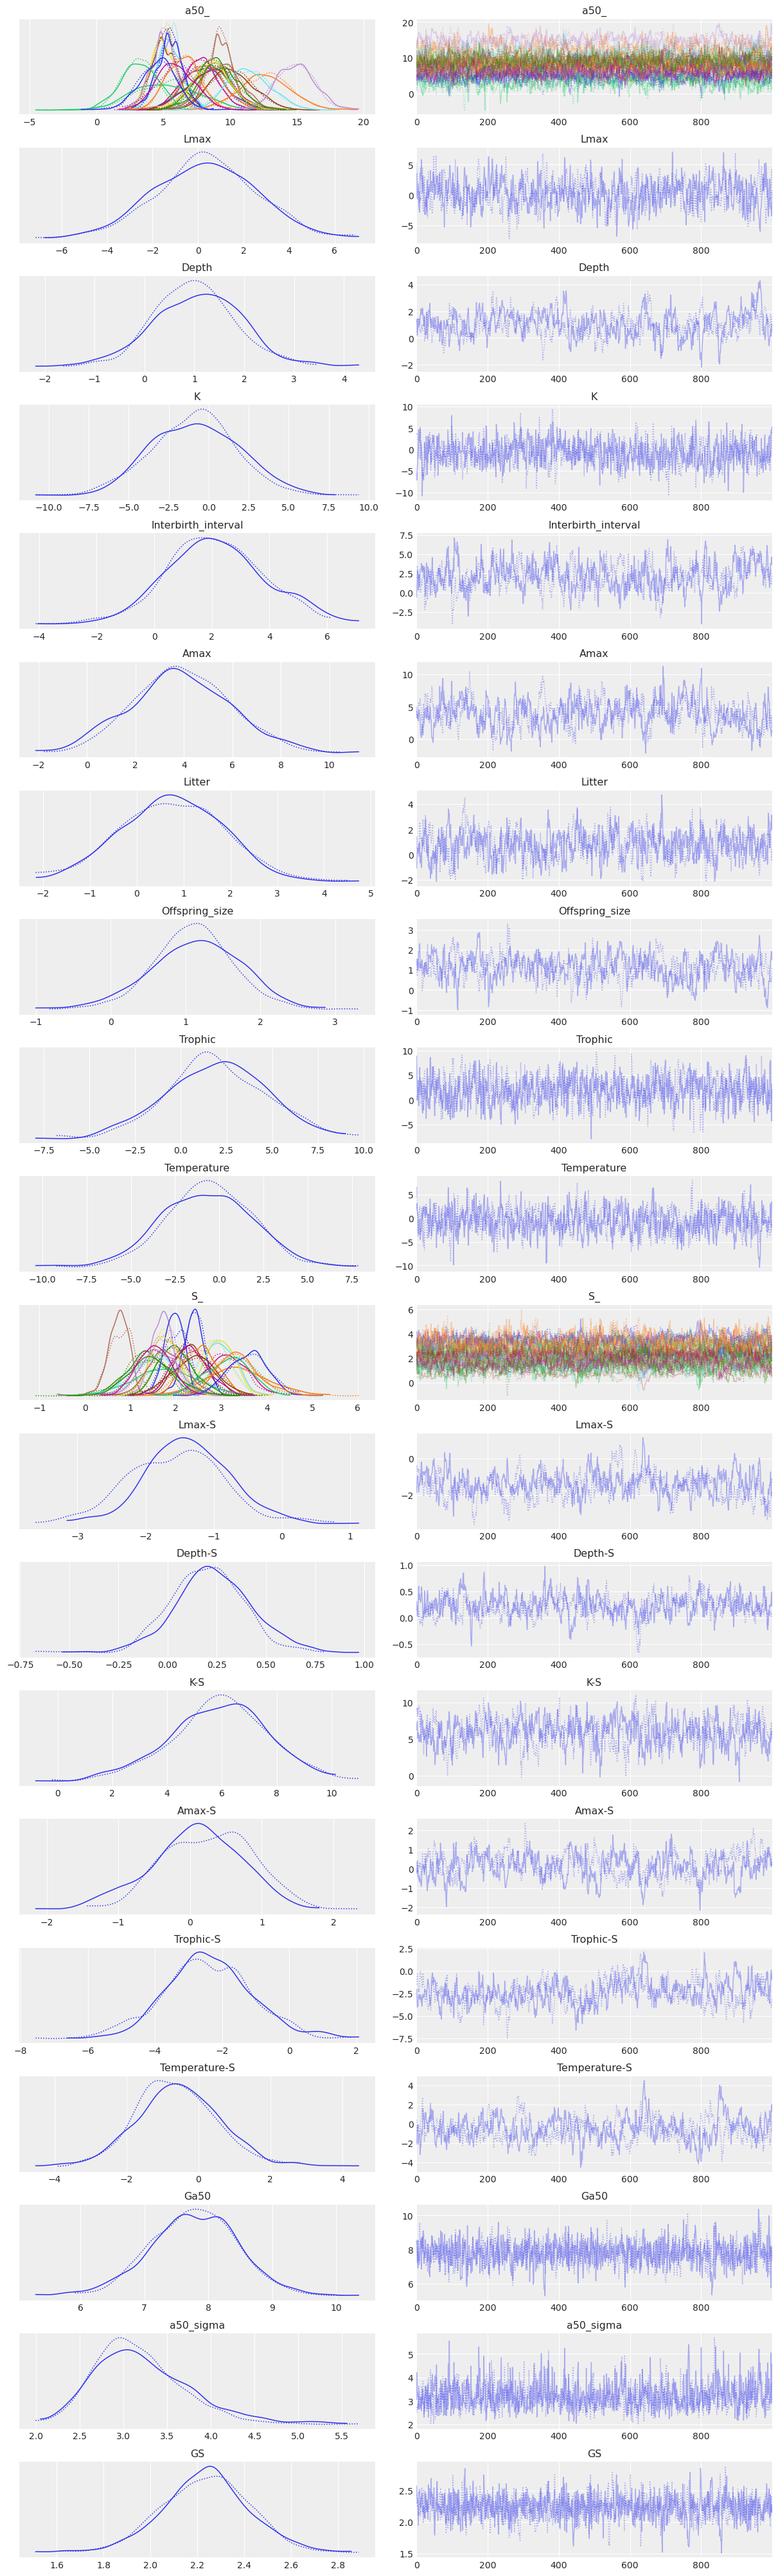

In [29]:
#check model performance
pm.traceplot(trace1);

In [32]:
pm.summary(trace1)[50:105]
# looking for r-hat valeus of 1 - shows that model is converging

C:\Users\tmgor\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
S_[17],3.206,0.495,2.291,4.090,0.047,0.034,111.0,107.0,109.0,296.0,1.02
S_[18],1.645,0.394,0.886,2.397,0.032,0.022,155.0,155.0,155.0,228.0,1.01
S_[19],1.818,0.394,1.051,2.559,0.032,0.022,155.0,155.0,155.0,220.0,1.01
S_[20],3.579,0.456,2.736,4.395,0.033,0.023,191.0,191.0,193.0,311.0,1.00
S_[21],3.360,0.474,2.526,4.325,0.038,0.027,155.0,155.0,148.0,501.0,1.01
S_[22],1.457,0.547,0.488,2.549,0.082,0.058,44.0,44.0,46.0,280.0,1.05
S_[23],1.518,0.380,0.783,2.182,0.033,0.024,132.0,122.0,131.0,420.0,1.02
Lmax-S,-1.455,0.689,-2.881,-0.210,0.060,0.043,131.0,131.0,132.0,172.0,1.02
Depth-S,0.215,0.199,-0.144,0.595,0.016,0.011,160.0,160.0,154.0,330.0,1.02
K-S,5.896,1.800,2.490,9.324,0.126,0.089,203.0,203.0,206.0,489.0,1.00


In [33]:
#WAIC for model 1
pm.waic(trace1, scale='deviance')

C:\Users\tmgor\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\tmgor\anaconda3\lib\site-packages\arviz\stats\stats.py:1466: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 by 516 log-likelihood matrix

              Estimate       SE
deviance_waic -3365.79   129.78
p_waic           93.21        -

There has been a warning during the calculation. Please check the results.

### Model Results

C:\Users\tmgor\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


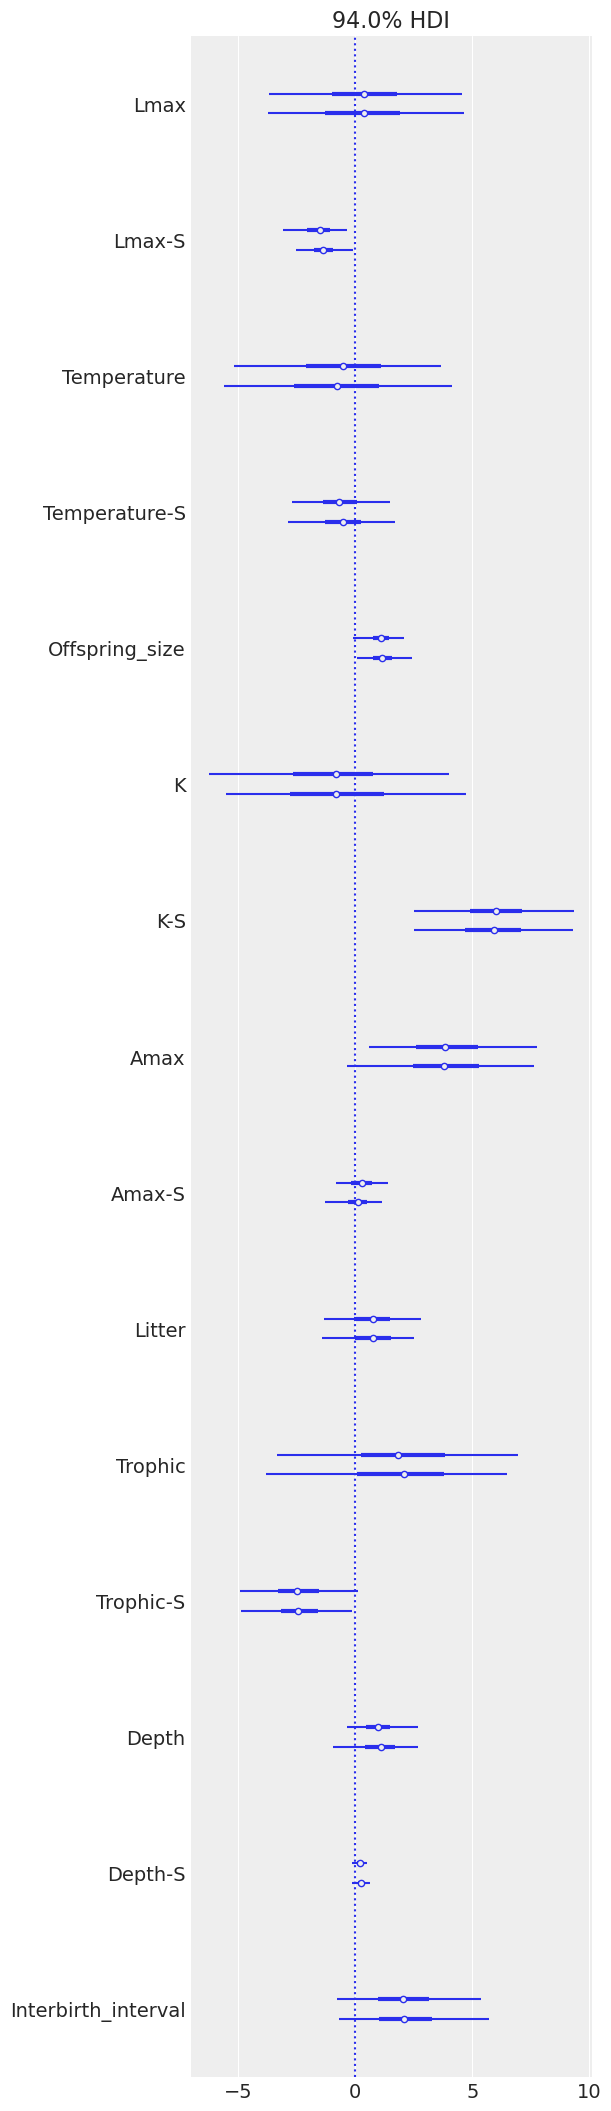

<Figure size 720x480 with 0 Axes>

In [34]:
# Forest plot to see size and direction of cov effects
# single forest version
az.style.use("arviz-darkgrid")
az.plot_forest(trace1, 
                var_names=["Lmax", "Lmax-S", "Temperature", "Temperature-S", "Offspring_size", "K", "K-S", "Amax", "Amax-S", "Litter", "Trophic", "Trophic-S", "Depth", "Depth-S", "Interbirth_interval"])
plt.axvline(0, linestyle=':')
plt.show()

#save figure
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
plt.savefig('mat34_forest.jpg');

In [ ]:
# Forest plot to see size and direction of cov effects
# Compare mat1 and mat2 (mixed effect vs fixed effect)
az.style.use("arviz-darkgrid")
axes = az.plot_forest(
    [trace1, trace2], model_names=["mixed-effect", "fixed-effect"], var_names=["Lmax", "Temperature", "Temperature-S", "Offspring_size", "K-S", "Amax", "Amax-S", "Litter", "Trophic", "Trophic-S", "Depth", "Depth-S", "Interbirth_interval"])
axes[0].set_title("Maturity effects")
plt.axvline(0, linestyle=':')
plt.show()


In [35]:
loo1 = pm.loo(trace1, mat1)
loo1

C:\Users\tmgor\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\tmgor\anaconda3\lib\site-packages\arviz\stats\stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 2000 by 516 log-likelihood matrix

         Estimate       SE
elpd_loo  1676.79    64.23
p_loo       99.32        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      471   91.3%
 (0.5, 0.7]   (ok)         16    3.1%
   (0.7, 1]   (bad)        20    3.9%
   (1, Inf)   (very bad)    9    1.7%

In [36]:
badpoints1 = mdata.iloc[loo1.pareto_k.values > 0.7]

### Plot model fits

In [37]:
#Save results to external file
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
#mat 34
result1 = pm.backends.tracetab.trace_to_dataframe(trace1)
result1.to_csv('mat34_model_results.csv')

In [41]:
result1.columns[10:60]

Index(['a50___10', 'a50___11', 'a50___12', 'a50___13', 'a50___14', 'a50___15',
       'a50___16', 'a50___17', 'a50___18', 'a50___19', 'a50___20', 'a50___21',
       'a50___22', 'a50___23', 'Lmax', 'Depth', 'K', 'Interbirth_interval',
       'Amax', 'Litter', 'Offspring_size', 'Trophic', 'Temperature', 'S___0',
       'S___1', 'S___2', 'S___3', 'S___4', 'S___5', 'S___6', 'S___7', 'S___8',
       'S___9', 'S___10', 'S___11', 'S___12', 'S___13', 'S___14', 'S___15',
       'S___16', 'S___17', 'S___18', 'S___19', 'S___20', 'S___21', 'S___22',
       'S___23', 'Lmax-S', 'Depth-S', 'K-S'],
      dtype='object')

In [43]:
# Grab data from mat34 results
# Grab a50's
μa50s = np.array([np.median(result1[x]) for x in np.array(['mu_a50__'+str(s) for s in list(range(len(StockYr)))])]).T
a50s = np.array([np.median(result1[x]) for x in np.array(['a50___'+str(s) for s in list(range(len(StockYr)))])]).T

# Grab S's
μSs = np.array([np.median(result1[x]) for x in np.array(['mu_S__'+str(s) for s in list(range(len(StockYr)))])]).T
Ss = np.array([np.median(result1[x]) for x in np.array(['S___'+str(s) for s in list(range(len(StockYr)))])]).T

# xrange
xr = np.linspace(0,max(AGE),max(AGE).astype(int)+1)

In [44]:
Ss

array([2.40971866, 3.34106802, 1.35627331, 3.09492128, 2.29213289,
       2.91553304, 2.91713194, 1.82289837, 1.72086559, 0.78017275,
       1.98728414, 2.53217722, 1.96751004, 2.29038405, 2.41468759,
       1.53253989, 1.73738248, 3.2332386 , 1.64017904, 1.81165479,
       3.60162432, 3.32785625, 1.44409859, 1.51512118])

### VIsualise model fit

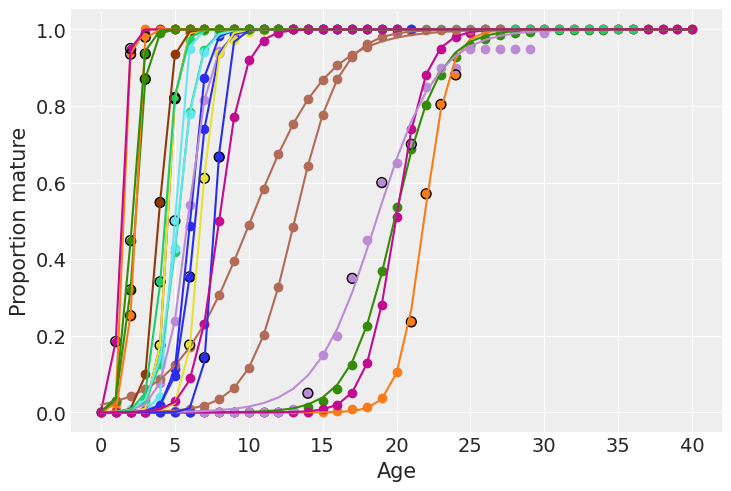

In [45]:
#plot model results against raw data - single plot model 1

#scatter plot of mat and age data
[plt.scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
#plot ogives with median S and mu_a50 values
[plt.plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(μSs,μa50s)]
# plot bad datapoints
plt.scatter(badpoints1.Age, badpoints1.maturity, facecolors='none', edgecolors='k', s=50)
#make plot pretty
plt.xlabel('Age',fontsize=15)
plt.ylabel('Proportion mature',fontsize=15)

#save results
plt.savefig('mat34_modelfit.jpg',dpi=300);

In [ ]:
#plot model results against raw data - double plot

nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,5))
ax_ = axes.flatten()

#Plot mat16
#scatter plot of mat and age data
[ax_[0].scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
# add markers for points with bad pareto k scores
ax_[0].scatter(badpoints1.Age, badpoints1.maturity, facecolors='none', edgecolors='k', s=50)
#plot ogives with median S and mu_a50 values
[ax_[0].plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(μSs,μa50s)]
#make plot pretty
ax_[0].set_xlabel('Age',fontsize=15)
ax_[0].set_ylabel('Proportion mature',fontsize=15)
ax_[0].set_title('mixed-effects')

#Plot mat17
#scatter plot of mat and age data
[ax_[1].scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
# add markers for poitns with high pareto k scores
ax_[1].scatter(badpoints2.Age, badpoints2.maturity, facecolors='none', edgecolors='k', s=50)
#plot ogives with median S and mu_a50 values
[ax_[1].plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(μSs2,μa50s2)]
#make plot pretty
ax_[1].set_xlabel('Age',fontsize=15)
ax_[1].set_ylabel('Proportion mature',fontsize=15)
ax_[1].set_title('fixed-effects')

#save results
plt.savefig('mat18_mat19_modelfit.jpg',dpi=300);